In [1]:
import pandas as pd

ds_names = [1,2,5,6,14,104]

data_samples = {}

for ds_name in ds_names:
    for i in range(1, 3):
        try:
            data_samples[f'{ds_name}_{i}'] = pd.read_csv(f'../data/winter_samples/dataset_{ds_name}_season_{i}.csv')
        except Exception as e:
            continue

## as X and y 

## NeuralForecast

In [2]:
import pandas as pd

records = []

for uid, df_series in data_samples.items():
    df_series = df_series.rename(columns={df_series.columns[1]: 'y'})
    df_series = df_series[['full_date', 'y']].copy()
    df_series['unique_id'] = uid
    df_series = df_series.rename(columns={'full_date': 'ds'})
    records.append(df_series)

df_all = pd.concat(records, ignore_index=True)

In [3]:
test_ids = ['1_2', '14_1']
test_df = df_all[df_all['unique_id'].isin(test_ids)]
train_df = df_all[~df_all['unique_id'].isin(test_ids)]

<Axes: >

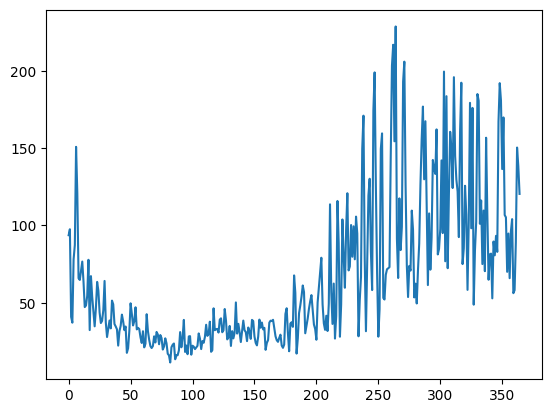

In [4]:
train_df[train_df['unique_id']=='1_1']['y'].plot()

In [5]:
horizon = 125
train_df = train_df.sort_values(['unique_id', 'ds'])

In [6]:
train_df

,ds,y,unique_id
3285,2019-03-16,39.425591,104_1
3286,2019-03-17,65.265278,104_1
3287,2019-03-18,49.719444,104_1
3288,2019-03-19,34.334260,104_1
3289,2019-03-20,65.029167,104_1
...,...,...,...
2915,2019-03-11,53.529576,6_2
2916,2019-03-12,68.687065,6_2
2917,2019-03-13,56.190410,6_2
2918,2019-03-14,55.816092,6_2


In [7]:
from neuralforecast.auto import AutoLSTM
from neuralforecast.tsdataset import TimeSeriesDataset

train_df['ds'] = pd.to_datetime(train_df['ds']) 
test_df['ds'] = pd.to_datetime(test_df['ds']) 
train_dataset, indices, dates, ds_arr = TimeSeriesDataset.from_df(
    df=train_df,
    id_col="unique_id",
    time_col="ds",
    target_col="y"
)
test_dataset, indices, dates, ds_arr = TimeSeriesDataset.from_df(
    df=test_df,
    id_col="unique_id",
    time_col="ds",
    target_col="y"
)

c:\Users\77019\pyver\py312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-17 17:57:19,573	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-04-17 17:57:19,997	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
C:\Users\77019\AppData\Local\Temp\ipykernel_1856\300558927.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['ds'] = pd.to_datetime(test_df['ds'])


In [14]:
from ray import tune

def optuna_config(trial):
    return {
        # "input_size_multiplier": trial.suggest_categorical("input_size_multiplier", [-1, 4, 16, 64]),
        # "inference_input_size_multiplier": -1,  # single value, no need to tune
        "h": None,  # set externally
        "encoder_hidden_size": trial.suggest_categorical("encoder_hidden_size", [16, 32, 64, 128]),
        "encoder_n_layers": trial.suggest_int("encoder_n_layers", 1, 3),  # randint(1, 4) → [1, 2, 3]
        # "context_size": trial.suggest_categorical("context_size", [5, 10, 50]),
        "decoder_hidden_size": trial.suggest_categorical("decoder_hidden_size", [16, 32, 64, 128]),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        "max_steps": trial.suggest_categorical("max_steps", [500, 1000]),
        "batch_size": trial.suggest_categorical("batch_size", [16, 32]),
        "loss": None,  # set externally
        "random_seed": trial.suggest_int("random_seed", 1, 19),  # randint(1, 20) → [1, 2, ..., 19]
        'start_padding_enabled': True,
        'input_size': 240
    }

model_lstm = AutoLSTM(h=horizon, num_samples=20, backend='optuna', config=optuna_config)

model_lstm.fit(dataset=train_dataset, distributed_config=None)
y_hat = model_lstm.predict(dataset=train_dataset)

[I 2025-04-16 14:25:48,617] A new study created in memory with name: no-name-38a83a40-5a44-47cf-abd1-3b9a2cab23c3
Seed set to 16
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 21.4 K | train
4 | mlp_decoder  | MLP           | 4.4 K  | train
-------------------------------------------------------
25.7 K    Trainable params
0         Non-trainable params
25.7 K    Total params
0.103     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-16 14:26:59,295] Trial 0 finished with value: 37.10231399536133 and parameters: {'encoder_hidden_size': 32, 'encoder_n_layers': 3, 'decoder_hidden_size': 128, 'learning_rate': 0.032856186219968574, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 16}. Best is trial 0 with value: 37.10231399536133.
Seed set to 18
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 4.5 K  | train
4 | mlp_decoder  | MLP           | 1.1 K  | train
-------------------------------------------------------
5.6 K     Trainable params
0         Non-trainable params
5.6 K     Total params
0.022     Total es

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-16 14:27:32,400] Trial 1 finished with value: 35.79218673706055 and parameters: {'encoder_hidden_size': 32, 'encoder_n_layers': 1, 'decoder_hidden_size': 32, 'learning_rate': 0.0025216951779921397, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 18}. Best is trial 1 with value: 35.79218673706055.
Seed set to 2
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 4.5 K  | train
4 | mlp_decoder  | MLP           | 545    | train
-------------------------------------------------------
5.0 K     Trainable params
0         Non-trainable params
5.0 K     Total params
0.020     Total est

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-04-16 14:27:47,944] Trial 2 finished with value: 38.1959228515625 and parameters: {'encoder_hidden_size': 32, 'encoder_n_layers': 1, 'decoder_hidden_size': 16, 'learning_rate': 0.0027815865579178156, 'max_steps': 500, 'batch_size': 16, 'random_seed': 2}. Best is trial 1 with value: 35.79218673706055.
Seed set to 19
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 331 K  | train
4 | mlp_decoder  | MLP           | 8.3 K  | train
-------------------------------------------------------
339 K     Trainable params
0         Non-trainable params
339 K     Total params
1.358     Total estima

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-16 14:32:24,340] Trial 3 finished with value: 47.95771789550781 and parameters: {'encoder_hidden_size': 128, 'encoder_n_layers': 3, 'decoder_hidden_size': 64, 'learning_rate': 0.002326927323739746, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 19}. Best is trial 1 with value: 35.79218673706055.
Seed set to 14
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 50.4 K | train
4 | mlp_decoder  | MLP           | 8.4 K  | train
-------------------------------------------------------
58.9 K    Trainable params
0         Non-trainable params
58.9 K    Total params
0.236     Total es

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-16 14:33:47,364] Trial 4 finished with value: 40.1839485168457 and parameters: {'encoder_hidden_size': 64, 'encoder_n_layers': 2, 'decoder_hidden_size': 128, 'learning_rate': 0.008896625462952362, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 14}. Best is trial 1 with value: 35.79218673706055.
Seed set to 11
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 199 K  | train
4 | mlp_decoder  | MLP           | 4.2 K  | train
-------------------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.813     Total est

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-04-16 14:35:18,008] Trial 5 finished with value: 42.299163818359375 and parameters: {'encoder_hidden_size': 128, 'encoder_n_layers': 2, 'decoder_hidden_size': 32, 'learning_rate': 0.00035923063734740656, 'max_steps': 500, 'batch_size': 32, 'random_seed': 11}. Best is trial 1 with value: 35.79218673706055.
Seed set to 18
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 5.6 K  | train
4 | mlp_decoder  | MLP           | 1.2 K  | train
-------------------------------------------------------
6.7 K     Trainable params
0         Non-trainable params
6.7 K     Total params
0.027     Total e

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-16 14:35:59,894] Trial 6 finished with value: 59.40221405029297 and parameters: {'encoder_hidden_size': 16, 'encoder_n_layers': 3, 'decoder_hidden_size': 64, 'learning_rate': 0.05197961523434381, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 18}. Best is trial 1 with value: 35.79218673706055.
Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 1.2 K  | train
4 | mlp_decoder  | MLP           | 289    | train
-------------------------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estim

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-04-16 14:36:11,591] Trial 7 finished with value: 44.047584533691406 and parameters: {'encoder_hidden_size': 16, 'encoder_n_layers': 1, 'decoder_hidden_size': 16, 'learning_rate': 0.05688754580972728, 'max_steps': 500, 'batch_size': 32, 'random_seed': 1}. Best is trial 1 with value: 35.79218673706055.
Seed set to 14
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 5.6 K  | train
4 | mlp_decoder  | MLP           | 577    | train
-------------------------------------------------------
6.1 K     Trainable params
0         Non-trainable params
6.1 K     Total params
0.025     Total estima

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-04-16 14:36:32,968] Trial 8 finished with value: 39.62746047973633 and parameters: {'encoder_hidden_size': 16, 'encoder_n_layers': 3, 'decoder_hidden_size': 32, 'learning_rate': 0.020954595879021116, 'max_steps': 500, 'batch_size': 16, 'random_seed': 14}. Best is trial 1 with value: 35.79218673706055.
Seed set to 5
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 67.1 K | train
4 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
83.7 K    Trainable params
0         Non-trainable params
83.7 K    Total params
0.335     Total estima

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-16 14:38:04,674] Trial 9 finished with value: 38.4451789855957 and parameters: {'encoder_hidden_size': 128, 'encoder_n_layers': 1, 'decoder_hidden_size': 128, 'learning_rate': 0.013417981999407387, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 5}. Best is trial 1 with value: 35.79218673706055.
Seed set to 8
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 4.5 K  | train
4 | mlp_decoder  | MLP           | 1.1 K  | train
-------------------------------------------------------
5.6 K     Trainable params
0         Non-trainable params
5.6 K     Total params
0.022     Total esti

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-16 14:38:35,082] Trial 10 finished with value: 48.39142990112305 and parameters: {'encoder_hidden_size': 32, 'encoder_n_layers': 1, 'decoder_hidden_size': 32, 'learning_rate': 0.00012451267263749796, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 8}. Best is trial 1 with value: 35.79218673706055.
Seed set to 16
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 12.9 K | train
4 | mlp_decoder  | MLP           | 4.4 K  | train
-------------------------------------------------------
17.3 K    Trainable params
0         Non-trainable params
17.3 K    Total params
0.069     Total e

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-16 14:39:26,140] Trial 11 finished with value: 39.38453674316406 and parameters: {'encoder_hidden_size': 32, 'encoder_n_layers': 2, 'decoder_hidden_size': 128, 'learning_rate': 0.0010196536696338843, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 16}. Best is trial 1 with value: 35.79218673706055.
Seed set to 11
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 21.4 K | train
4 | mlp_decoder  | MLP           | 4.4 K  | train
-------------------------------------------------------
25.7 K    Trainable params
0         Non-trainable params
25.7 K    Total params
0.103     Total 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-16 14:40:34,235] Trial 12 finished with value: 41.37432098388672 and parameters: {'encoder_hidden_size': 32, 'encoder_n_layers': 3, 'decoder_hidden_size': 128, 'learning_rate': 0.0053167859290256065, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 11}. Best is trial 1 with value: 35.79218673706055.
Seed set to 16
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 12.9 K | train
4 | mlp_decoder  | MLP           | 1.1 K  | train
-------------------------------------------------------
14.0 K    Trainable params
0         Non-trainable params
14.0 K    Total params
0.056     Total 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-16 14:41:22,243] Trial 13 finished with value: 36.595523834228516 and parameters: {'encoder_hidden_size': 32, 'encoder_n_layers': 2, 'decoder_hidden_size': 32, 'learning_rate': 0.001051266816424403, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 16}. Best is trial 1 with value: 35.79218673706055.
Seed set to 14
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 50.4 K | train
4 | mlp_decoder  | MLP           | 2.1 K  | train
-------------------------------------------------------
52.5 K    Trainable params
0         Non-trainable params
52.5 K    Total params
0.210     Total e

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-16 14:42:37,981] Trial 14 finished with value: 45.70823669433594 and parameters: {'encoder_hidden_size': 64, 'encoder_n_layers': 2, 'decoder_hidden_size': 32, 'learning_rate': 0.000800195830746358, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 14}. Best is trial 1 with value: 35.79218673706055.
Seed set to 19
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 4.5 K  | train
4 | mlp_decoder  | MLP           | 1.1 K  | train
-------------------------------------------------------
5.6 K     Trainable params
0         Non-trainable params
5.6 K     Total params
0.022     Total es

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-16 14:43:08,287] Trial 15 finished with value: 35.413780212402344 and parameters: {'encoder_hidden_size': 32, 'encoder_n_layers': 1, 'decoder_hidden_size': 32, 'learning_rate': 0.0006369104104086991, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 19}. Best is trial 15 with value: 35.413780212402344.
Seed set to 19
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 4.5 K  | train
4 | mlp_decoder  | MLP           | 1.1 K  | train
-------------------------------------------------------
5.6 K     Trainable params
0         Non-trainable params
5.6 K     Total params
0.022     Tota

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-16 14:43:38,550] Trial 16 finished with value: 45.90483093261719 and parameters: {'encoder_hidden_size': 32, 'encoder_n_layers': 1, 'decoder_hidden_size': 32, 'learning_rate': 0.00026878003777051424, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 19}. Best is trial 15 with value: 35.413780212402344.
Seed set to 8
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 4.5 K  | train
4 | mlp_decoder  | MLP           | 1.1 K  | train
-------------------------------------------------------
5.6 K     Trainable params
0         Non-trainable params
5.6 K     Total params
0.022     Total

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-16 14:44:09,103] Trial 17 finished with value: 37.99806213378906 and parameters: {'encoder_hidden_size': 32, 'encoder_n_layers': 1, 'decoder_hidden_size': 32, 'learning_rate': 0.00046641345033452514, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 8}. Best is trial 15 with value: 35.413780212402344.
Seed set to 17
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 17.2 K | train
4 | mlp_decoder  | MLP           | 2.1 K  | train
-------------------------------------------------------
19.3 K    Trainable params
0         Non-trainable params
19.3 K    Total params
0.077     Total

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-04-16 14:44:31,617] Trial 18 finished with value: 39.21652603149414 and parameters: {'encoder_hidden_size': 64, 'encoder_n_layers': 1, 'decoder_hidden_size': 32, 'learning_rate': 0.0017818610160711425, 'max_steps': 500, 'batch_size': 16, 'random_seed': 17}. Best is trial 15 with value: 35.413780212402344.
Seed set to 13
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 4.5 K  | train
4 | mlp_decoder  | MLP           | 2.2 K  | train
-------------------------------------------------------
6.7 K     Trainable params
0         Non-trainable params
6.7 K     Total params
0.027     Total e

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-16 14:45:03,561] Trial 19 finished with value: 40.2962532043457 and parameters: {'encoder_hidden_size': 32, 'encoder_n_layers': 1, 'decoder_hidden_size': 64, 'learning_rate': 0.00012479469404605791, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 13}. Best is trial 15 with value: 35.413780212402344.
Seed set to 19
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 4.5 K  | train
4 | mlp_decoder  | MLP           | 1.1 K  | train
-------------------------------------------------------
5.6 K     Trainable params
0         Non-trainable params
5.6 K     Total params
0.022     Total

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [25]:
y_pred_test = model_lstm.predict(test_dataset)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [41]:
forecast_dict = {}
for i in range(len(y_pred_test)//horizon):
    forecast_dict[test_ids[i]] = y_pred_test[i*horizon:(i+1)*horizon]

In [64]:
def count_metrics(model_name, params, test_df, y_hat, test_lengths):
    test_df_copy = test_df.copy()
    test_df_copy['forecast'] = y_hat

    error_dict = {}
    for test_length in test_lengths:
        eval_subset = test_df_copy.iloc[:test_length]  # Take subset for evaluation
        error_dict[f"test_{test_length}_days"] = mape_met(eval_subset['y'].values,  eval_subset['forecast'].values)

    monthly_error_dict = defaultdict(dict)
    test_df_copy['year'] = test_df_copy['ds'].dt.year
    test_df_copy['month'] = test_df_copy['ds'].dt.month

    # Group by year and month and calculate MAPE for each group
    grouped = test_df_copy.groupby(['year', 'month'])
    for (year, month), group in grouped:
        if not group.empty:
            monthly_error_dict[year][month] = mape_met(group['y'].values, group['forecast'].values)

    return {
        "Model": model_name,
        **error_dict,  # Expand error dictionary into separate columns
        **monthly_error_dict,
        "preds": test_df_copy['forecast'].values,
        "params": params,
    }

In [ ]:
count_metrics('lstm', model_lstm.model.hparams, test_df, y_hat, test_lengths)

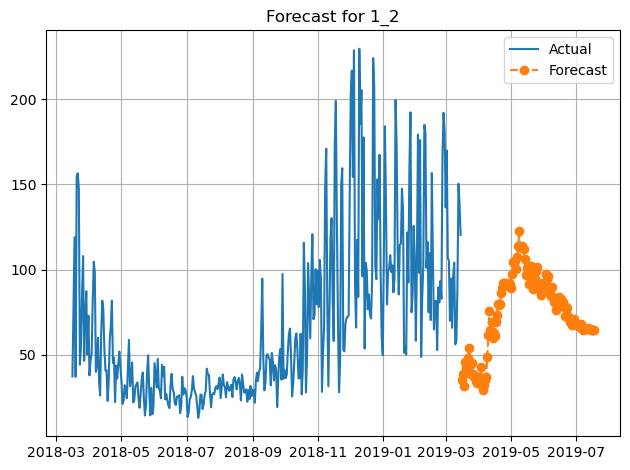

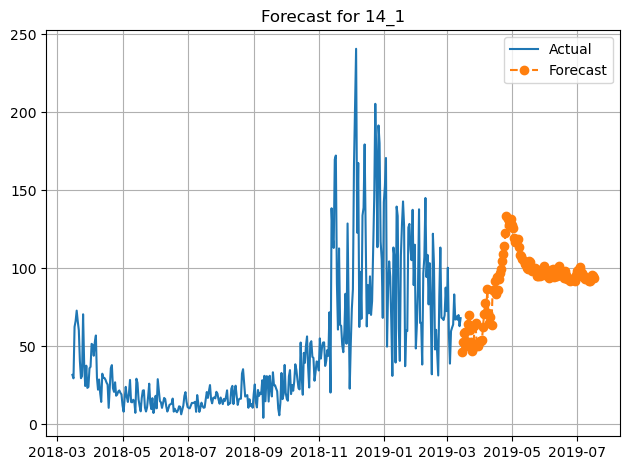

In [51]:
import matplotlib.pyplot as plt

for uid in test_df['unique_id'].unique():
    uid_test_df = test_df[test_df['unique_id'] == uid].copy()
    actual_data = uid_test_df['y']
    actual_dates = pd.to_datetime(uid_test_df['ds'])
    
    # Find the last date in the actual data
    last_date = pd.to_datetime(actual_dates.max())
    
    # Generate future dates based on your frequency (daily assumed here)
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=horizon)
    
    # Get the corresponding forecasts
    predicted_values = forecast_dict[uid]

    # Plot actual data
    plt.figure()
    plt.plot(actual_dates, actual_data, label='Actual')
    
    # Plot forecasts
    plt.plot(future_dates, predicted_values, label='Forecast', linestyle='--', marker='o')
    
    plt.title(f"Forecast for {uid}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [27]:
y_pred_test.shape

(250, 1)

In [17]:
y_hat.shape

(1000, 1)

In [15]:
from neuralforecast.auto import AutoMLP

def optuna_config(trial):
    return {
        # 🔒 Fixed values
        "start_padding_enabled": True,
        "input_size": trial.suggest_int("num_layers", 2, 240),

        # 🔧 Tuned values
        "step_size": trial.suggest_categorical("step_size", [1, horizon]),
        "hidden_size": trial.suggest_categorical("hidden_size", [256, 512, 1024]),
        "num_layers": trial.suggest_int("num_layers", 2, 5),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        "scaler_type": trial.suggest_categorical("scaler_type", [None, "robust", "standard"]),
        "max_steps": trial.suggest_categorical("max_steps", [500, 1000]),
        "batch_size": trial.suggest_categorical("batch_size", [32, 64, 128, 256]),
        "windows_batch_size": trial.suggest_categorical("windows_batch_size", [128, 256, 512, 1024]),
        "loss": None,
        "random_seed": trial.suggest_int("random_seed", 1, 19),
    }
model_mlp = AutoMLP(
    h=horizon,
    backend="optuna",
    config=optuna_config,
    num_samples=20,
)
